# Imports 

In [1]:
import pycaret

In [2]:
import pandas as pd
from pandas.api.types import CategoricalDtype

import datetime as dt
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

from statsmodels.stats.outliers_influence import variance_inflation_factor as VIF
from sklearn.linear_model import LinearRegression

import itertools
from tqdm import tqdm

import sys
sys.path.append('./functions')
from functions import (
    logistic_regression_diagnostic_plots,
    diagnostic_plots,
    calculate_vif,
    remove_high_vif_features,
    evaluate,
    plot_sensitivity_specificity,
    aic_scorer,
    select_model_by_aic,
    view_logistic_regression_coefficients,
    calculate_cooks_distance
)

In [3]:
# Helper functions 

def max_log_likelihood(y, preds):
    nobs = len(y)
    resid = y - preds
    ssr = np.sum(resid**2)
    mllh = -0.5 * nobs * np.log(2 * np.pi) - 0.5 * nobs * np.log(ssr / nobs) - 0.5 * nobs
    return mllh

def aic(y, preds, p):
    mllh = max_log_likelihood(y, preds)
    return -2 * mllh + 2 * p

import pandas as pd
from sklearn.model_selection import train_test_split
from statsmodels.regression.linear_model import OLS
from statsmodels.tools import add_constant
import numpy as np

def forward_selection(data, response_variable, test_size=0.33, random_state=42):
    """
    Perform forward selection to find the best model based on AIC.

    Args:
        data (DataFrame): The input DataFrame containing all predictor variables and the response variable.
        response_variable (str): The name of the response variable column in `data`.
        test_size (float): The proportion of the dataset to include in the test split.
        random_state (int): The seed used by the random number generator for reproducible results.

    Returns:
        A tuple containing the best model and the list of selected variables.
    """
    # Prepare data
    y = data[response_variable]
    X = data.drop(columns=[response_variable])

    # Splitting the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    # Adding a constant for OLS
    X_train_const = add_constant(X_train)

    # Initialize variables
    selected_vars = []
    remaining_vars = X_train.columns.tolist()
    best_aic = np.inf
    best_model = None

    while remaining_vars:
        aic_with_var = []
        for var in remaining_vars:
            # Try adding this variable to the selected variables
            trial_vars = selected_vars + [var]
            trial_X = X_train_const[trial_vars + ['const']]
            model = OLS(y_train, trial_X).fit()
            aic_with_var.append((model.aic, var))
        
        # Find the variable that, when added, results in the lowest AIC
        aic_with_var.sort()
        best_aic_candidate, best_var_candidate = aic_with_var[0]
        
        if best_aic_candidate < best_aic:
            # If this model is better, select this variable and update the best AIC
            best_aic = best_aic_candidate
            selected_vars.append(best_var_candidate)
            remaining_vars.remove(best_var_candidate)
            best_model = model
        else:
            break

    return best_model, selected_vars


import pandas as pd
from sklearn.model_selection import train_test_split
from statsmodels.regression.linear_model import OLS
from statsmodels.tools import add_constant
import numpy as np

def backward_elimination(data, response_variable, test_size=0.33, random_state=42):
    """
    Perform backward elimination to find the best model based on AIC.

    Args:
        data (DataFrame): The input DataFrame containing all predictor variables and the response variable.
        response_variable (str): The name of the response variable column in `data`.
        test_size (float): The proportion of the dataset to include in the test split.
        random_state (int): The seed used by the random number generator for reproducible results.

    Returns:
        A tuple containing the best model and the list of selected variables.
    """
    # Prepare data
    y = data[response_variable]
    X = data.drop(columns=[response_variable])

    # Splitting the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    # Adding a constant for OLS
    X_train_const = add_constant(X_train)

    # Start with all variables
    remaining_vars = X_train_const.columns.tolist()
    best_aic = np.inf
    best_model = None

    while remaining_vars:
        aic_with_var = []
        for var in remaining_vars:
            # Try removing this variable and see the AIC
            trial_vars = [v for v in remaining_vars if v != var]
            trial_X = X_train_const[trial_vars]
            model = OLS(y_train, trial_X).fit()
            aic_with_var.append((model.aic, var))
        
        # Find the variable whose removal results in the lowest AIC
        aic_with_var.sort()
        best_aic_candidate, worst_var_candidate = aic_with_var[0]

        if best_aic_candidate < best_aic:
            # If this model is better, remove this variable and update the best AIC
            best_aic = best_aic_candidate
            remaining_vars.remove(worst_var_candidate)
            best_model = model
#             print(f'Removing {worst_var_candidate} improved AIC to {best_aic}')
        else:
#             print("No more improvement")
            break

    return best_model, remaining_vars


# Load the Data

In [4]:
df_los = pd.read_csv('./data/los_cleaned.csv')

### Develop the target variable

In [5]:
# For each row, we will subtract the row’s ALOS from its GM-LOS and multiply by $1,000.
df_los.loc[:, 'LOSDiscrepancyCost'] = -(df_los['LOS'] - df_los['GM-LOS'] * 1000)
df_los = df_los.dropna(subset=['LOSDiscrepancyCost'])

#### Data cleaning. 

In [6]:
# Here we can see that there are only 4 observations of this category (which doesn't allow us to treat this as a ordinal var)
# therfor, let us drop it 
df_los = df_los.drop(df_los[df_los['riskOfMortality'] == '0-Ungroupable'].index)

# These are weird NA values. Let us explicitly make them NAs
df_los['principalProcedure'] = df_los['principalProcedure'].replace('-', np.nan)

In [7]:
len(df_los)

8119

In [8]:
df_los.head()

,patientID,dischargeQTR,month,admitType,dischargeStatus,admittedDOW,hospital,ageGroup,sex,race,...,principalProcedure,procPosCnt,productLine,altProductLine1,altProductLine1SUB,payCode,LOS,LOSGroupName,totalCharge,LOSDiscrepancyCost
0,73473237,1,3,Emergency,Discharged to Home or Self Care,5,Medical Center Hospital,25-29,Male,Black,...,NaN,0,General Medicine,General Medicine,Infectious Disease - Medical,Unknown,9,9 to 14 Days,52284.92,4891.000095
1,72495275,1,1,Emergency,Discharged to Home or Self Care,3,South Hospital,45-49,Female,White,...,NaN,0,Gastroenterology,General Medicine,Gastrointestinal Disease - Medical,Other Non-Federal Program,2,1 to 2 Days,20362.83,2797.999952
2,74993343,3,7,Emergency,Discharged to Home or Self Care,3,Medical Center Hospital,45-49,Male,White,...,NaN,0,Neurology,Neurology,Stroke and TIA,Point of Service,1,1 to 2 Days,35683.34,2199.000048
3,74600869,2,6,Emergency,Discharged to Home or Self Care,6,Medical Center Hospital,55-59,Female,White,...,NaN,0,General Medicine,General Medicine,Infectious Disease - Medical,Health Maintenance Organization (HMO),2,1 to 2 Days,17722.19,4898.000095
4,76013130,3,9,Emergency,Discharged/Transferred to Home Under Care of O...,0,Medical Center Hospital,18-19,Female,Black,...,"5A1D70Z-PERFORMANCE OF URINARY FILTRATION, <6 ...",1,Cardiac (Medical),Cardiovascular,Cardiology - Medical,Medicare Part A,4,3 to 5 Days,50306.04,3095.999905


## Get descriptive statistics

In [9]:
import pandas as pd

# Initialize a dictionary to store the values
data_dict = {
    'Metric': [],
    'Value': []
}

# Number of cases
num_cases = len(df_los)
data_dict['Metric'].append('Number of Cases')
data_dict['Value'].append(num_cases)

# Average GM-LOS
avg_gm_los = df_los['GM-LOS'].mean()
data_dict['Metric'].append('Average GM-LOS')
data_dict['Value'].append(avg_gm_los)

# Average CMI
avg_cmi = df_los['caseMixIndex'].mean()
data_dict['Metric'].append('Average CMI')
data_dict['Value'].append(avg_cmi)

# Split dataframe into 2 hospitals
df_mch = df_los[df_los['hospital'] == df_los['hospital'].unique()[0]]
df_sh = df_los[df_los['hospital'] == df_los['hospital'].unique()[1]]

# Average LOS for each hospital
# Medical Center Hospital
avg_mch_los = df_mch['LOS'].mean()
# South Hospital
avg_sh_los = df_sh['LOS'].mean()

data_dict['Metric'].append('Medical Center Hospital LOS')
data_dict['Value'].append(avg_mch_los)

data_dict['Metric'].append('South Hospital LOS')
data_dict['Value'].append(avg_sh_los)

# Create a DataFrame from the dictionary
metrics_df = pd.DataFrame(data_dict)

# Print the DataFrame
metrics_df

,Metric,Value
0,Number of Cases,8119.000000
1,Average GM-LOS,4.114386
2,Average CMI,1.688306
3,Medical Center Hospital LOS,4.678143
4,South Hospital LOS,3.499690


### How much money would each hospital save if they could get their LOSDiscrepancyCost to 0 for every patient?

In [10]:
mch_neg_values = pd.DataFrame()
mch_neg_values['LOSDiscrepancyCost'] = df_mch[df_mch['LOSDiscrepancyCost'] > 0]['LOSDiscrepancyCost']
mch_money_saved = mch_neg_values.sum()[0]

sh_neg_values = pd.DataFrame()
sh_neg_values['LOSDiscrepancyCost'] = df_sh[df_sh['LOSDiscrepancyCost'] > 0]['LOSDiscrepancyCost']
sh_money_saved = sh_neg_values.sum()[0]

print('MCH Money Saved:', f'${mch_money_saved:,.2f}')
print('SH Money Saved:', f'${sh_money_saved:,.2f}')

MCH Money Saved: $26,729,964.05
SH Money Saved: $6,638,654.99


### What product lines have the greatest opportunity for improvement in terms of patient days?
Group by (product line) -> avg. sort by highest to lowest cost.
### Visualize with bar charts.


In [11]:
# isolate vars that are negative

pl_improvement = df_los.groupby('productLine').sum(numeric_only=True).sort_values(by = 'LOSDiscrepancyCost', ascending = False)['LOSDiscrepancyCost']
pl_improvement = pd.DataFrame(pl_improvement)
pl_improvement.reset_index(inplace=True)
pl_improvement.head()

,productLine,LOSDiscrepancyCost
0,General Medicine,7.238977e+06
1,Pulmonology,5.828597e+06
2,General Surgery,5.584802e+06
3,Gastroenterology,2.713769e+06
4,Orthopedics,2.527706e+06


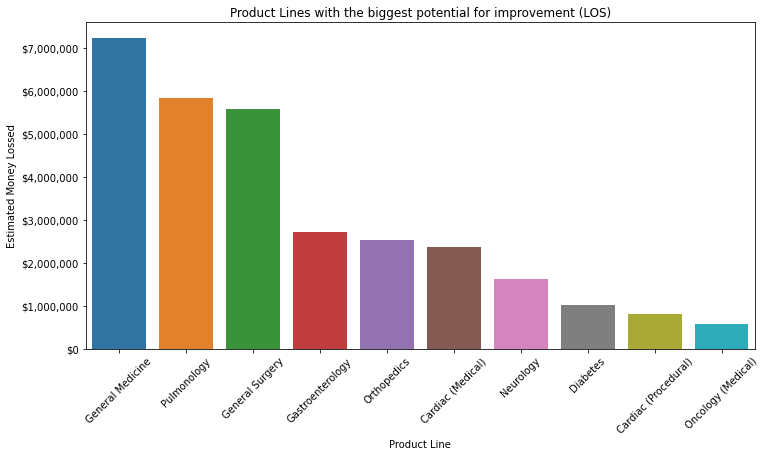

In [12]:
plt.figure(figsize=(12,6))

# Function to format y-axis labels to display numerical values in dollars with commas
def format_y_tick_labels(value, pos):
    return f'${value:,.0f}'

# Create the barplot
sns.barplot(x='productLine', y='LOSDiscrepancyCost', data=pl_improvement.head(10))

# Rotate x-axis labels
plt.xticks(rotation=45)

# Format y-axis labels using the formatter function
plt.gca().yaxis.set_major_formatter(FuncFormatter(format_y_tick_labels))


plt.title('Product Lines with the biggest potential for improvement (LOS)')
plt.xlabel('Product Line')
plt.ylabel('Estimated Money Lossed')

# Show the plot
plt.show()


### Within the product line with the greatest opportunity for improvement (identified above), which DRG has the greatest opportunity for improvement?  Answer the questions: What is this diagnosis? Why is it difficult for hospitals to manage?
- Within the product line identified above, group by (DRG) -> avg. sort by highest to lowest cost.
 - Visualize with bar charts.


In [13]:
# isolate vars that are negative
gen_med = df_los[df_los['productLine'] == 'General Medice']
drg_improvement = df_los.groupby(['APR DRG']).sum(numeric_only=True).sort_values(by = 'LOSDiscrepancyCost', ascending = False)['LOSDiscrepancyCost']
drg_improvement = pd.DataFrame(drg_improvement)
drg_improvement.reset_index(inplace=True)
drg_improvement.head()

,APR DRG,LOSDiscrepancyCost
0,720-Septicemia & Disseminated Infections,3.960901e+06
1,137-Major Respiratory Infections & Inflammations,3.607219e+06
2,194-Heart Failure,1.347988e+06
3,710-Infectious & Parasitic Diseases Including ...,1.003919e+06
4,231-Major large bowel procedures,7.922490e+05


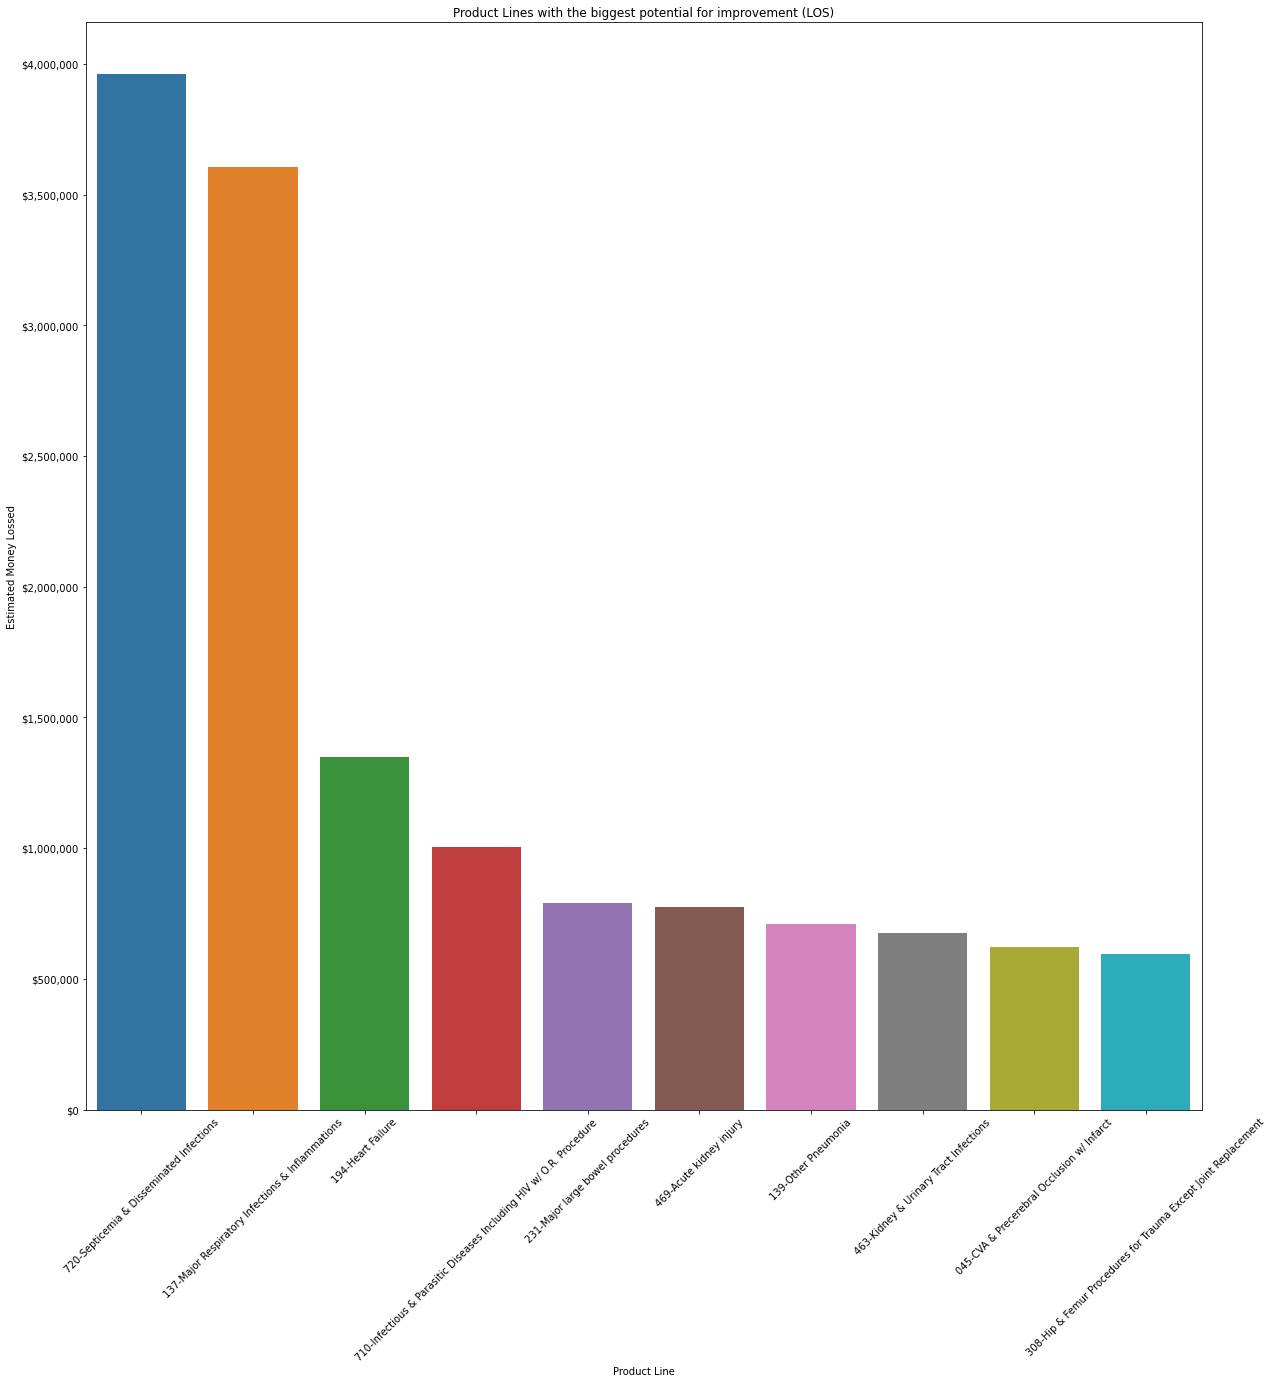

In [14]:
# @$@ clean this up later

plt.figure(figsize=(20,20))

# Create the barplot
sns.barplot(x='APR DRG', y='LOSDiscrepancyCost', data=drg_improvement.head(10))

# Rotate x-axis labels
plt.xticks(rotation=45)

# Format y-axis labels using the formatter function
plt.gca().yaxis.set_major_formatter(FuncFormatter(format_y_tick_labels))


plt.title('Product Lines with the biggest potential for improvement (LOS)')
plt.xlabel('Product Line')
plt.ylabel('Estimated Money Lossed')

# Show the plot
plt.show()

### Build a predictive model focused on interpretability that uses the patient demographic data to see which group of patients is expected to have the highest variance in length of stay. Build a predictive model that focuses on predictive power rather than interpretability that allows hospitals to more accurately predict LOS deviation.
- Linear Regression for interpretable model
- Try other types of models, for predictive purposes. Support vector machines, random forest etc.

In [15]:
regress_me = df_los.drop(
    ['dischargeQTR',
     "patientID", # IRRELEVANT BC EACH IS UNIQUE
    "LOS", # WOULD BE TOO CORELATED WITH TARGET
    "LOSGroupName", # WOULD BE TOO CORELATED WITH TARGET
    "totalCharge", # CAN'T LOOK INTO THE FUTURE
    "dischargeStatus", # CAN'T LOOK INTO THE FUTURE
    "principleDiagnosisCode",
     'hospital',
    "principalProcedureCode", 
    "altProductLine1", # KISS
    "altProductLine1SUB", # KISS
    'AM-LOS', # WOULD BE TOO CORELATED WITH TARGET
    'GM-LOS', # WOULD BE TOO CORELATED WITH TARGET
     'hospital', # LATER SPLIT AND DO REGRESSION ON EACH SO BOTH, HOS1, HOS2,
     'APR DRG', # KISS MAYBE ADD LATER,
     'dischargeQTR', # will be a less specific month
     'principalProcedure',# KISS ADD LATER
     'principalDiagnosis',
     'caseMixIndex',
#      'payCode' # UNETHICAL
#      'principalProcedure' # KISS
    ], axis=1)

severity_mapping = {
    '1-Minor': 1,
    '2-Moderate': 2, 
    '3-Major': 3,
    '4-Extreme': 4
}

regress_me['severity'] = regress_me['severity'].map(severity_mapping)
regress_me['riskOfMortality'] = regress_me['riskOfMortality'].map(severity_mapping)

age_group_mapping = {
    '18-19': (18 + 19) / 2,
    '20-24': (20 + 24) / 2,
    '25-29': (25 + 29) / 2,
    '30-34': (30 + 34) / 2,
    '35-39': (35 + 39) / 2,
    '40-44': (40 + 44) / 2,
    '45-49': (45 + 49) / 2,
    '50-54': (50 + 54) / 2,
    '55-59': (55 + 59) / 2,
    '60-64': (60 + 64) / 2,
    '65-69': (65 + 69) / 2,
    '70-74': (70 + 74) / 2,
    '75-79': (75 + 79) / 2,
    '80-84': (80 + 84) / 2,
    '85-89': (85 + 89) / 2,
    '90+': 90
}

dow_map = {0: 'Mon', 1: 'Tue', 2: 'Wed', 3: 'Thu', 4: 'Fri', 5: 'Sat', 6: 'Sun'}

regress_me['admittedDOW'] = regress_me['admittedDOW'].map(dow_map)


month_map = {
    1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr',
    5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug',
    9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'
}

regress_me['month'] = regress_me['month'].map(month_map)



regress_me = regress_me.drop(columns = 'ageGroup')

regress_me = pd.get_dummies(regress_me)

# VIF

In [16]:
y = regress_me['LOSDiscrepancyCost']
X = regress_me.drop(columns ='LOSDiscrepancyCost')
kept, removed = remove_high_vif_features(X = X, y = y, vif_threshold =  10)

In [17]:
len(removed)
removed

['month_Apr',
 'admitType_Elective',
 'admittedDOW_Fri',
 'sex_Female',
 'race_American Indian / Eskimo / Aleut',
 'ethnicity_Blinded Ethnicity',
 'productLine_Behavioral Health',
 'payCode_Champus',
 'ethnicity_Not Hispanic or Latino',
 'productLine_General Medicine',
 'race_White',
 'payCode_Medicare Part A']

# AIC Selection

In [18]:
from sklearn.model_selection import train_test_split
from statsmodels.regression.linear_model import OLS
from statsmodels.tools import add_constant
import numpy as np
from sklearn import linear_model

# Assuming 'regress_me' and 'kept' are defined correctly in your workspace
y = regress_me['LOSDiscrepancyCost']
X = kept

# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Adding a constant to X_train for statsmodels
X_train_const = add_constant(X_train)

# p is the number of features plus one for the intercept
p = X_train_const.shape[1]

# Linear regression using sklearn
lr = linear_model.LinearRegression()
lr.fit(X_train, y_train)
preds = lr.predict(X_test)

# Forward Selection

In [19]:
best_for_model, selected_for_variables = forward_selection(regress_me, 'LOSDiscrepancyCost')
print("Best model summary:", best_for_model.summary())

Best model summary:                             OLS Regression Results                            
Dep. Variable:     LOSDiscrepancyCost   R-squared:                       0.547
Model:                            OLS   Adj. R-squared:                  0.545
Method:                 Least Squares   F-statistic:                     261.3
Date:                Sat, 27 Apr 2024   Prob (F-statistic):               0.00
Time:                        17:07:06   Log-Likelihood:                -46838.
No. Observations:                5439   AIC:                         9.373e+04
Df Residuals:                    5413   BIC:                         9.390e+04
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------

# Backwards Selection

In [20]:
# # FORWARD IS SIMPLER SO LETS GO WITH THAT
# best_back_model, selected_back_variables = backward_elimination(regress_me, 'LOSDiscrepancyCost')
# print("Best model summary:", best_back_model.summary())

# Pycaret -- A powerful predicting model # 

In [21]:
regress_me_train, regress_me_test = train_test_split(regress_me, test_size=0.33, random_state=42)

In [22]:
from pycaret.regression import setup, compare_models, predict_model

# Assuming you have split your data and run setup for regress_me_train
s = setup(data=regress_me_train, target='LOSDiscrepancyCost', session_id=27)

# Comparing models and selecting the best
best_model = compare_models()

# Predicting using the best model: PyCaret handles preprocessing
predictions = predict_model(best_model, data=regress_me_test)


,Description,Value
0,Session id,27
1,Target,LOSDiscrepancyCost
2,Target type,Regression
3,Original data shape,"(5439, 75)"
4,Transformed data shape,"(5439, 75)"
5,Transformed train set shape,"(3807, 75)"
6,Transformed test set shape,"(1632, 75)"
7,Numeric features,74
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,633.7865,1089707.0922,1038.7362,0.7164,0.2133,0.1589,0.0660
gbr,Gradient Boosting Regressor,668.4678,1103212.3380,1044.0716,0.7132,0.2228,0.1723,0.0690
rf,Random Forest Regressor,616.5132,1121913.1832,1049.2188,0.7086,0.2148,0.1548,0.2730
knn,K Neighbors Regressor,721.1257,1483380.9000,1211.3465,0.6143,0.2492,0.1763,0.0220
et,Extra Trees Regressor,735.6012,1600421.7685,1259.1028,0.5864,0.2511,0.1835,0.3300
lasso,Lasso Regression,883.2932,1873599.3787,1361.2848,0.5242,0.2818,0.2278,0.3950
br,Bayesian Ridge,884.6903,1876694.5019,1362.2518,0.5238,0.2816,0.2279,0.0110
ridge,Ridge Regression,884.8406,1878774.6294,1363.1429,0.5229,0.2831,0.2285,0.0090
lr,Linear Regression,885.2058,1881175.9037,1364.0370,0.5222,0.2835,0.2286,0.6780
llar,Lasso Least Angle Regression,890.1835,1894175.8278,1368.7207,0.5193,0.2822,0.2291,0.0090


Processing:   0%|          | 0/77 [00:00<?, ?it/s]

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,649.4055,1223576.7435,1106.1540,0.7114,0.2300,0.1664


In [23]:
predictions = predict_model(best_model, data=regress_me_test)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,649.4055,1223576.7435,1106.1540,0.7114,0.2300,0.1664


In [24]:
from pycaret.regression import tune_model

# Define a custom grid (as an example)
custom_grid = {
    'learning_rate': [0.001, 0.01, 0.1],
    'n_estimators': [100, 500, 1000],
    'num_leaves': [20, 30, 40],
    'min_child_samples': [10, 20, 30],
    'max_depth': [-1, 10, 20]
}

# Tune the model
optimized_model = tune_model(
    estimator=best_model, 
    fold=10, 
    round=4, 
    n_iter=50,  # More iterations
    custom_grid=custom_grid, 
    optimize='RMSE',  # Focusing on minimizing RMSE
#     search_library='optuna',  # Using Optuna for optimization
    early_stopping=True, 
    early_stopping_max_iters=10,
    choose_better=True,  # Choose the better model between original and tuned
    verbose=True,
    tuner_verbose=True
)

# Display the optimized model
# print(optimized_model)
predict_model(optimized_model, data=regress_me_test)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,650.5754,1177868.3412,1085.2964,0.7471,0.2125,0.1590
1,552.2104,815958.8699,903.3044,0.7969,0.1807,0.1389
2,569.2646,838785.4247,915.8523,0.6286,0.2024,0.1497
3,621.9557,891672.8488,944.2843,0.7495,0.2121,0.1647
4,618.1954,963985.7040,981.8277,0.6909,0.2268,0.1741
5,563.1391,801761.0191,895.4111,0.8316,0.1873,0.1388
6,687.5071,1393720.8038,1180.5595,0.6360,0.2300,0.1748
7,690.6071,1697693.2473,1302.9556,0.6504,0.2261,0.1601
8,671.7929,1392300.2435,1179.9577,0.6658,0.2195,0.1625


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 50 candidates, totalling 500 fits


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,629.7755,1066421.8852,1032.6770,0.7484,0.2195,0.1641


,APR_DRG,severity,riskOfMortality,diagPosCnt,procPosCnt,month_Apr,month_Aug,month_Dec,month_Feb,month_Jan,...,payCode_Medicare Part A,payCode_Other Federal Programs,payCode_Other Non-Federal Program,payCode_Point of Service,payCode_Preferred Provider Organization (PPO),payCode_Unknown,payCode_Veteran Admin Plan,payCode_Worker's Comp Health Claim,LOSDiscrepancyCost,prediction_label
8436,44,3,2,11,4,0,1,0,0,0,...,0,0,0,0,0,1,0,0,4398.0,5313.137228
4380,468,3,2,15,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,3497.0,3935.543476
1963,137,4,4,24,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,5677.0,5604.261750
9242,340,2,2,17,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,2898.0,3358.126890
2890,720,4,3,24,4,0,0,1,0,0,...,1,0,0,0,0,0,0,0,4885.0,6721.653043
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5320,696,2,2,14,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,3497.0,5020.942379
3138,253,2,2,19,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,3095.0,3269.642039
5965,720,4,4,24,8,0,0,0,0,0,...,0,0,0,0,0,0,0,0,12481.0,9725.006592
3107,207,1,2,20,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1897.0,2423.434054


In [28]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from tqdm.auto import tqdm

# Assuming previously defined X_train, y_train, X_test, y_test

# Define your parameter grid
param_grid = {
    'max_features': ['sqrt', 'log2', max(1, X_train.shape[1]//3), max(1, X_train.shape[1]//2), X_train.shape[1]],
    'n_estimators': [100, 500, 1000],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Set up the model
rf_reg = RandomForestRegressor(random_state=27)

# Use GridSearchCV
grid_search = GridSearchCV(estimator=rf_reg, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Extract best model from grid search
best_rf = grid_search.best_estimator_

# Best parameters without 'mean_score' or any other non-parameter info
best_params = grid_search.best_params_

# Set the best parameters to the model
rf_reg.set_params(**best_params)

# Fit the best model
rf_reg.fit(X_train, y_train)

# Make predictions with the best model
rf_preds = rf_reg.predict(X_test)

# Calculate MSE
rf_mse = mean_squared_error(y_test, rf_preds)

print("Best model parameters:", best_params)
print("MSE of the best model:", rf_mse)


# Fitting 5 folds for each of 135 candidates, totalling 675 fits
# Best model parameters: {'max_features': 58, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 500}
# MSE of the best model: 1103691.1674982284

Fitting 5 folds for each of 135 candidates, totalling 675 fits
Best model parameters: {'max_features': 62, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 500}
MSE of the best model: 1113783.435476772


In [27]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from tqdm.auto import tqdm

rf_reg1 = RandomForestRegressor(random_state=27)
rf_reg1.set_params(**{'max_features': 58, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 500})

# Calculate MSE
rf_mse = mean_squared_error(y_test, rf_preds)

print("Best model parameters:", best_params)
print("MSE of the best model:", rf_mse)

NameError: name 'rf_preds' is not defined

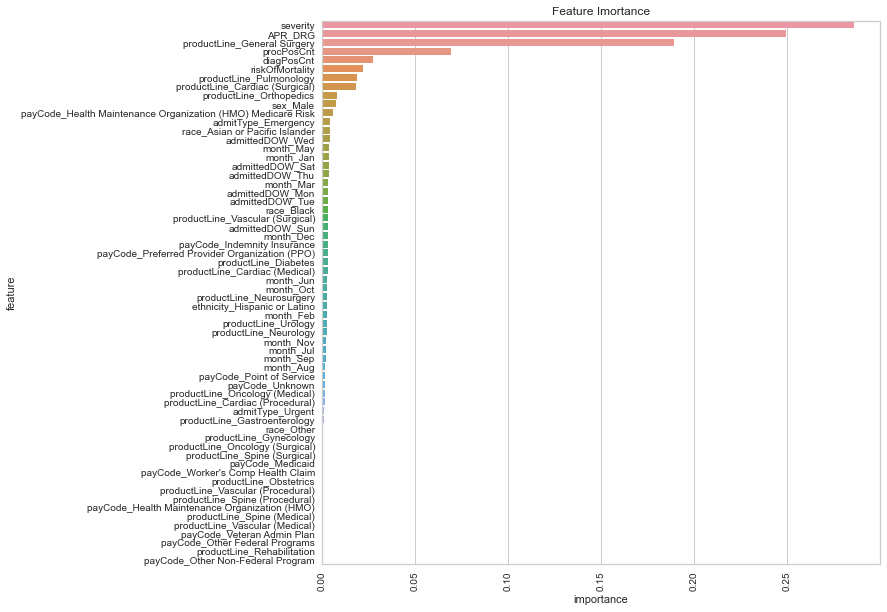

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Create a DataFrame with feature names and their importance scores
plot_df = pd.DataFrame({
    'feature': X_train.columns,  # Use the column names from the DataFrame
    'importance': rf_reg.feature_importances_  # Feature importances from the RandomForestRegressor
})

# Plotting feature importances
plt.figure(figsize=(10, 10))
sns.barplot(x='importance', y='feature', data=plot_df.sort_values('importance', ascending=False))
plt.xticks(rotation=90)
plt.title('Feature Imortance')
plt.show()

# DOW ANOVA AND POST HOC

In [30]:
for col in df_los.columns:
    print(col)

patientID
dischargeQTR
month
admitType
dischargeStatus
admittedDOW
hospital
ageGroup
sex
race
ethnicity
AM-LOS
GM-LOS
caseMixIndex
APR_DRG
APR DRG
severity
riskOfMortality
principleDiagnosisCode
principalDiagnosis
diagPosCnt
principalProcedureCode
principalProcedure
procPosCnt
productLine
altProductLine1
altProductLine1SUB
payCode
LOS
LOSGroupName
totalCharge
LOSDiscrepancyCost


In [31]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Fit ANOVA model
model = ols('LOS ~ C(admittedDOW)', data=df_los).fit()
anova_results = sm.stats.anova_lm(model, typ=2)  # Type 2 ANOVA DataFrame
print(anova_results)
print('\n\n')


# Perform Tukey's HSD test
posthoc = pairwise_tukeyhsd(df_los['LOS'], df_los['admittedDOW'], alpha=0.05)
print(posthoc)


                       sum_sq      df         F    PR(>F)
C(admittedDOW)     244.311502     6.0  2.166814  0.043136
Residual        152439.995678  8112.0       NaN       NaN



Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
     0      1  -0.1205 0.9922 -0.6224 0.3815  False
     0      2  -0.0164    1.0 -0.5245 0.4916  False
     0      3   0.0662 0.9998 -0.4452 0.5777  False
     0      4   0.2659 0.7261 -0.2462  0.778  False
     0      5   0.3559 0.4331 -0.1765 0.8882  False
     0      6  -0.1768 0.9623 -0.7195 0.3659  False
     1      2    0.104 0.9969 -0.4105 0.6185  False
     1      3   0.1867 0.9387 -0.3311 0.7045  False
     1      4   0.3863  0.297 -0.1322 0.9048  False
     1      5   0.4763 0.1234 -0.0622 1.0148  False
     1      6  -0.0563 0.9999 -0.6051 0.4924  False
     2      3   0.0827 0.9992  -0.441 0.6064  False
     2      4   0.2823 0.6904 -0.2421 0.806

# AGE ANOVA AND POST HOC

In [32]:
df_los['ageGroup']

0       25-29
1       45-49
2       45-49
3       55-59
4       18-19
        ...  
9669    20-24
9670    75-79
9671    55-59
9672    70-74
9673    35-39
Name: ageGroup, Length: 8119, dtype: object

In [33]:
# AGE ANOVA
# ANOVA for 'Age'
model_age = ols('LOS ~ C(ageGroup)', data=df_los).fit()
anova_age = sm.stats.anova_lm(model_age, typ=2)
print(anova_age)
print('\n\n')

# Perform Tukey's HSD test
age_posthoc = pairwise_tukeyhsd(df_los['LOS'], df_los['admittedDOW'], alpha=0.05)
print(age_posthoc)


                    sum_sq      df        F        PR(>F)
C(ageGroup)    2306.849220    15.0  8.28688  4.025989e-19
Residual     150377.457961  8103.0      NaN           NaN



Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
     0      1  -0.1205 0.9922 -0.6224 0.3815  False
     0      2  -0.0164    1.0 -0.5245 0.4916  False
     0      3   0.0662 0.9998 -0.4452 0.5777  False
     0      4   0.2659 0.7261 -0.2462  0.778  False
     0      5   0.3559 0.4331 -0.1765 0.8882  False
     0      6  -0.1768 0.9623 -0.7195 0.3659  False
     1      2    0.104 0.9969 -0.4105 0.6185  False
     1      3   0.1867 0.9387 -0.3311 0.7045  False
     1      4   0.3863  0.297 -0.1322 0.9048  False
     1      5   0.4763 0.1234 -0.0622 1.0148  False
     1      6  -0.0563 0.9999 -0.6051 0.4924  False
     2      3   0.0827 0.9992  -0.441 0.6064  False
     2      4   0.2823 0.6904 -0.2421 0.806

# RACE ANOVA AND POST HOC

In [34]:
# RACE ANOVA
# ANOVA for 'race'
model_race = ols('LOS ~ C(race)', data=df_los).fit()
anova_race = sm.stats.anova_lm(model_age, typ=2)
print(anova_race)
print('\n\n')

# Perform Tukey's HSD test
race_posthoc = pairwise_tukeyhsd(df_los['LOS'], df_los['race'], alpha=0.05)
print(race_posthoc)

                    sum_sq      df        F        PR(>F)
C(ageGroup)    2306.849220    15.0  8.28688  4.025989e-19
Residual     150377.457961  8103.0      NaN           NaN



                      Multiple Comparison of Means - Tukey HSD, FWER=0.05                       
             group1                        group2          meandiff p-adj   lower  upper  reject
------------------------------------------------------------------------------------------------
American Indian / Eskimo / Aleut Asian or Pacific Islander  -1.0757 0.7429  -3.492 1.3405  False
American Indian / Eskimo / Aleut                     Black   -0.894 0.8472 -3.2901 1.5022  False
American Indian / Eskimo / Aleut                     Other  -1.2349 0.6387 -3.6712 1.2014  False
American Indian / Eskimo / Aleut                     White  -0.9393 0.8166 -3.3107 1.4321  False
       Asian or Pacific Islander                     Black   0.1818  0.929 -0.4337 0.7973  False
       Asian or Pacific Islander               

In [35]:
# sex ANOVA
# ANOVA for 'sex'
model_sex = ols('LOS ~ C(sex)', data=df_los).fit()
anova_sex = sm.stats.anova_lm(model_age, typ=2)
print(anova_sex)
print('\n\n')

# Perform Tukey's HSD test
sex_posthoc = pairwise_tukeyhsd(df_los['LOS'], df_los['sex'], alpha=0.05)
print(sex_posthoc)

                    sum_sq      df        F        PR(>F)
C(ageGroup)    2306.849220    15.0  8.28688  4.025989e-19
Residual     150377.457961  8103.0      NaN           NaN



Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower  upper  reject
--------------------------------------------------
Female   Male   0.2279 0.0196 0.0366 0.4193   True
--------------------------------------------------


In [36]:
# eth ANOVA
# ANOVA for 'race'
model_eth = ols('LOS ~ C(ethnicity)', data=df_los).fit()
anova_eth = sm.stats.anova_lm(model_age, typ=2)
print(anova_race)
print('\n\n')

# Perform Tukey's HSD test
eth_posthoc = pairwise_tukeyhsd(df_los['LOS'], df_los['ethnicity'], alpha=0.05)
print(eth_posthoc)

                    sum_sq      df        F        PR(>F)
C(ageGroup)    2306.849220    15.0  8.28688  4.025989e-19
Residual     150377.457961  8103.0      NaN           NaN



              Multiple Comparison of Means - Tukey HSD, FWER=0.05               
      group1               group2         meandiff p-adj   lower   upper  reject
--------------------------------------------------------------------------------
 Blinded Ethnicity     Hispanic or Latino  -2.3629 0.8493 -12.5357 7.8099  False
 Blinded Ethnicity Not Hispanic or Latino  -2.5761 0.8234 -12.7429 7.5907  False
Hispanic or Latino Not Hispanic or Latino  -0.2132 0.4028  -0.6017 0.1753  False
--------------------------------------------------------------------------------
